In [1]:
from probe_experiment import *
from handcrafted_datasets import Dataset
from models import *
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
dataset = Dataset('captured', 'C:\\Users\\andre\\go-ai\\data', 0.8, 0.2, 1024)

def get_train_loader():
    dataset.shuffle('train')
    return dataset.loader('train', max_ram_files=25)

def get_test_loader():
    return dataset.loader('test', max_ram_files=25)

done loading data
split sizes:
train 552
test 138


In [3]:
def flatten_bce_loss(pred, target):
    return torch.nn.BCEWithLogitsLoss()(pred, nn.Flatten()(target))
criterion = flatten_bce_loss

In [4]:
go_model = load_go_model_from_ckpt('model_ckpt.pth.tar', rm_prefix=True)
feat_models = [CutModel(go_model, i).cuda() for i in range(8)]
n_channels = [8, 64, 64, 64, 48, 48, 32, 32]
probe_models = [nn.Sequential(nn.Conv2d(nc, 1, 19, padding=9), nn.Flatten()).cuda() for nc in n_channels]

In [5]:
aucs = []
for depth in range(0, 8):
    print('probing at depth %d' % depth)
    feat_model = feat_models[depth]
    probe_model = probe_models[depth]
    exp = ProbeExperiment(get_train_loader, get_test_loader, feat_model)
    config = {'name':'captured/captured_19x19cnn_d%d'%depth, 'write_log':True, 'progress_bar':False, 'save_ckpt':False}
    optimizer = torch.optim.Adam(probe_model.parameters())
    exp.run(probe_model, criterion, optimizer, 4, config)
    preds, labels = exp.get_predictions(probe_model, get_test_loader())
    auc = roc_auc_score(labels.flatten(), preds.flatten())
    aucs.append(auc)
    print(auc)

probing at depth 0
[LOG] epoch 0 loss 0.056987, new best
[LOG] epoch 1 loss 0.051480, new best
[LOG] epoch 2 loss 0.047815, new best
[LOG] epoch 3 loss 0.044979, new best
0.9290607192506029
probing at depth 1
[LOG] epoch 0 loss 0.029893, new best
[LOG] epoch 1 loss 0.024130, new best
[LOG] epoch 2 loss 0.022324, new best
[LOG] epoch 3 loss 0.021743, new best
0.987991664627094
probing at depth 2
[LOG] epoch 0 loss 0.037651, new best
[LOG] epoch 1 loss 0.032219, new best
[LOG] epoch 2 loss 0.029825, new best
[LOG] epoch 3 loss 0.029530, new best
0.9694191833471042
probing at depth 3
[LOG] epoch 0 loss 0.033354, new best
[LOG] epoch 1 loss 0.029789, new best
[LOG] epoch 2 loss 0.028880, new best
[LOG] epoch 3 loss 0.028120, new best
0.9748617505238877
probing at depth 4
[LOG] epoch 0 loss 0.042748, new best
[LOG] epoch 1 loss 0.038598, new best
[LOG] epoch 2 loss 0.036595, new best
[LOG] epoch 3 loss 0.037537
0.9526331872264885
probing at depth 5
[LOG] epoch 0 loss 0.052276, new best
[LOG

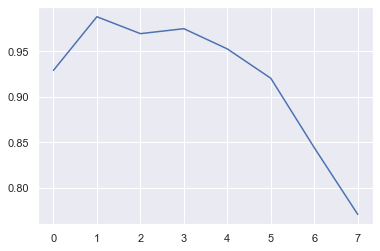

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
plt.plot(aucs)